In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import time
import shutil
sys.path.insert(0, '..')

from database.dataset import INBreast_Dataset
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from mc_candidate_proposal.hdog_mc import HDoGCalcificationDetection
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection

from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
from pathlib import Path

import warnings
import seaborn as sns
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Define experiment runers

Morphology

In [2]:
def run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle):
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()

    m_results_path = results_path / 'morphology'
    m_results_path.mkdir(exist_ok=True, parents=True)

    rbd_path = m_results_path / 'recounstructed_by_dialation_img'
    if rbd_path.exists():
        shutil.rmtree(rbd_path)
    rbd_path.mkdir(exist_ok=True, parents=True)

    result_det = {}
    res = []
    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        md = MorphologyCalcificationDetection(
            rbd_path, threshold=threshold, min_distance=min_distance,
            area=area*area, store_intermediate=False, filter_muscle_region=filter_muscle)

        start = time.time()
        if filter_muscle:
            candidate_blobs = md.detect(image, image_id, muscle_mask)
        else:
            candidate_blobs = md.detect(image, image_id)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            candidate_blobs, lesion_mask, None, 14)
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}

        res.append(img_res)
        result_det[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
    results_morphology = pd.DataFrame(res)
    filename = f'md_th-{threshold}_mindist-{min_distance}_area-{area}'
    results_morphology.to_csv(results_path/f'{filename}.csv')
    with open(results_path/f'{filename}.pkl', 'wb') as f:
        pickle.dump(result_det, f)

HDoG

In [3]:
def run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle):
    
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()
    
    hdog_results_path = results_path / 'HDoG'
    hdog_results_path.mkdir(exist_ok=True, parents=True)

    processed_imgs_path = hdog_results_path / 'hdog_images'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    processed_imgs_path.mkdir(exist_ok=True, parents=True)

    detections_path = hdog_results_path / 'hdog_detections'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    if detections_path.exists():
        shutil.rmtree(detections_path)
    detections_path.mkdir(exist_ok=True, parents=True)

    result_det = {}
    res = []

    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        hdogd = HDoGCalcificationDetection(
            dog_parameters, hessian_parameters, processed_imgs_path, detections_path,
            filter_muscle_region=filter_muscle)
        
        start = time.time()
        if filter_muscle:
            detections = hdogd.detect(image, image_id, False, False, muscle_mask)
        else:
            detections = hdogd.detect(image, image_id, False, False)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            detections, lesion_mask, None, 14)
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}

        res.append(img_res)
        result_det[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}

    results_hdog = pd.DataFrame(res)

    ms = dog_parameters['min_sigma']
    Ms = dog_parameters['max_sigma']
    ns = dog_parameters['n_scales']
    ns = dog_parameters['n_scales']
    dth = dog_parameters['dog_blob_th']
    dovp = dog_parameters['dog_overlap']
    dmd = dog_parameters['dog_min_dist']
    filename = f'hdog_ms-{ms}_Ms-{Ms}_ns-{ns}_dth-{dth}_dovp-{dovp}_dmd-{dmd}'
    results_hdog.to_csv(results_path/f'{filename}.csv')
    with open(results_path/f'{filename}.pkl', 'wb') as f:
        pickle.dump(result_det, f)

Hough

In [4]:
def run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius,
    erosion_iter, erosion_size, min_hough2_distance, db, results_path, filter_muscle
):
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()

    hough_results_path = results_path / 'Hough'
    hough_results_path.mkdir(exist_ok=True, parents=True)

    processed_imgs_path = hough_results_path / 'hough_images'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    processed_imgs_path.mkdir(exist_ok=True, parents=True)

    result_det_h1 = {}
    result_det_h2 = {}
    res_h1 = []
    res_h2 = []

    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        hd = HoughCalcificationDetection(
            dehazing_params, back_ext_radius, processed_imgs_path, hough1_params, hough2_params,
            erosion_iter=erosion_iter, erosion_size=erosion_size, min_hough2_dist=min_hough2_distance,
            filter_muscle_region=filter_muscle)

        start = time.time()
        if filter_muscle:
            h1_circles, h2_circles = hd.detect(image, image_id,
                load_processed_images=False, hough2=True, muscle_mask=muscle_mask)
        else:
            h1_circles, h2_circles = hd.detect(image, image_id,
                load_processed_images=False, hough2=True)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(h1_circles, lesion_mask, None, 14)
        result_det_h1[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res_h1 = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}
        res_h1.append(img_res_h1)

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(h2_circles, lesion_mask, None, 14)
        result_det_h2[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res_h2 = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}
        res_h2.append(img_res_h2)

    results_hough_h1 = pd.DataFrame(res_h1)
    results_hough_h2 = pd.DataFrame(res_h2)

    filename = f'hough_default'
    results_hough_h1.to_csv(results_path/f'{filename}_h1.csv')
    with open(results_path/f'{filename}_h1.pkl', 'wb') as f:
        pickle.dump(result_det_h1, f)

    results_hough_h2.to_csv(results_path/f'{filename}_h2.csv')
    with open(results_path/f'{filename}_h2.pkl', 'wb') as f:
        pickle.dump(result_det_h2, f)

In [10]:
def plot_results(results_path):
    filename = 'md_th-0.95_mindist-6_area-14'
    results_morphology95 = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_morphology95['method'] = 'gs_morph_095'

    filename = 'md_th-0.97_mindist-6_area-14'
    results_morphology = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_morphology['method'] = 'gs_morph_097'

    filename = 'hdog_ms-1_Ms-3_ns-20_dth-0.006_dovp-0.2_dmd-6'#'hdog_ms-1_Ms-3_ns-20_dth-0.006_dmd-6'
    results_hdog = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_hdog['method'] = 'hdog'

    results_hough_h1 = pd.read_csv(results_path/'hough_default_h1.csv', index_col=0)
    results_hough_h1['method'] = 'hough_h1'
    results_hough_h2 = pd.read_csv(results_path/'hough_default_h2.csv', index_col=0)
    results_hough_h2['method'] = 'hough_h2'

    results = pd.concat([results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2], ignore_index=True)
    results['FPR'] = results['FP'] / (results['FP'] + results['TP'])
    results['mfpi'] = (results['FP'] / len(results)).sum()
    results['sens'] = results['TP'] / (results['TP'] + results['FN'])
    results['sens_wod'] = results['TP_wo_dup'] / (results['TP_wo_dup'] + results['FN'])
    results.loc[~results.normal, 'fp_per_tp'] = results['FP'] / (results['TP'])
    results.loc[(~results.normal) & (results.sens==0), 'fp_per_tp'] = results['FP']
    results.loc[results.normal, 'fp_per_tp'] = results['FP']

    melt_results = pd.melt(results, id_vars=['method'], value_vars=['sens', 'sens_wod'])

    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity vs method')
    sns.boxplot(data=results, x='method', y='sens')
    sns.despine()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity wo_d vs method')
    sns.boxplot(data=results, x='method', y='sens_wod')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity comparison')
    sns.boxplot(data=melt_results, x='method', y='value', hue='variable')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per tp per image vs method')
    sns.boxplot(data=results, x='method', y='fp_per_tp')
    plt.ylim(0, 2000)
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per tp per image vs method')
    sns.boxplot(data=results, x='method', y='fp_per_tp')
    plt.yscale('log')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per image on normal images vs method')
    sns.boxplot(data=results.loc[results.normal], x='method', y='fp_per_tp')
    plt.ylim(0, 25000)
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('Computation time per image vs method')
    sns.boxplot(data=results, x='method', y='time')
    # plt.yscale('log')
    sns.despine()
    plt.ylabel('time [s]')
    plt.ylim([0, 70])
    plt.show()


## Run experiments with pectoral supression

In [6]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=True,
    ignore_diameter_px = 15
)

In [7]:
results_path = Path.cwd().parent.parent / 'data/comparisson_between_detectors_wo_pectoral_wod/'
results_path.mkdir(exist_ok=True, parents=True)

In [ ]:
# GSM
threshold = 0.97
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=True)

threshold = 0.95
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=True)


# HDOG
dog_parameters = {
    'min_sigma': 1,
    'max_sigma': 3,
    'n_scales': 20,
    'sigma_ratio': None,
    'dog_blob_th': 0.006,
    'dog_overlap': 0.2,
    'dog_min_dist': 6,
}

hessian_parameters = {
    'method': 'eigenval',
    'hessian_threshold': None,
    'hessian_th_divider': 300
}

run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle=True)


# HOUGH

dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 10,
                 'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}
hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 3,  'minRadius': 2, 'maxRadius': 10}

back_ext_radius = 50
erosion_iter = 20
erosion_size = 5
min_hough2_distance = 6

run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius, erosion_iter,
    erosion_size, min_hough2_distance, db, results_path, filter_muscle=True
)


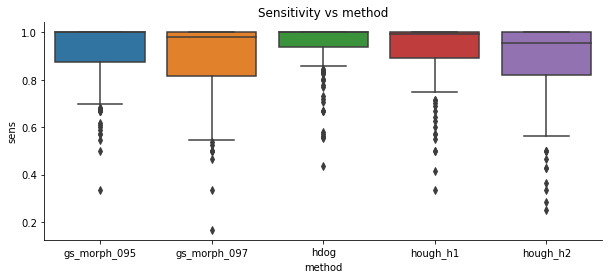

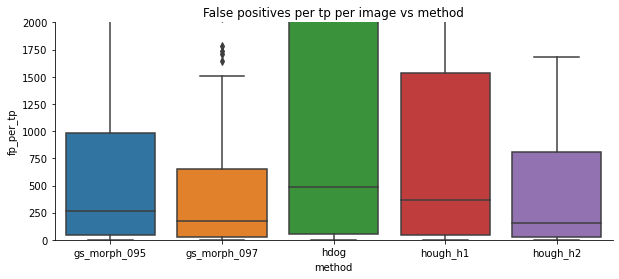

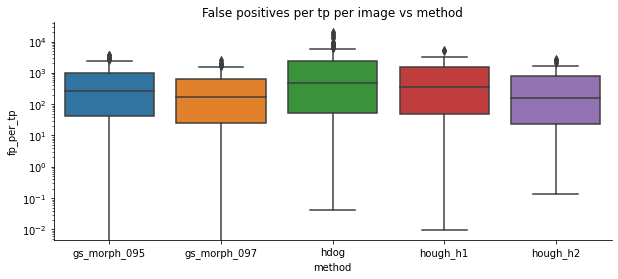

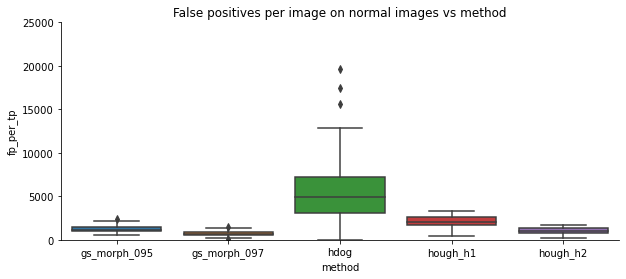

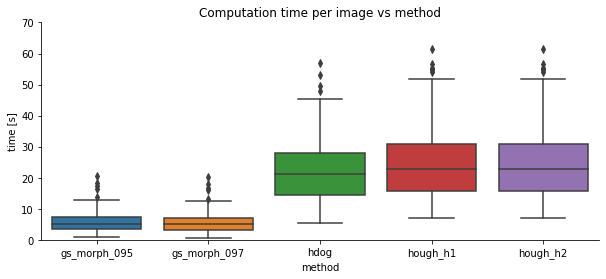

In [16]:
# RESULTS
plot_results(results_path)

## Run experiments without pectoral supression

In [6]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [17]:
results_path = Path.cwd().parent.parent / 'data/comparisson_between_detectors_w_pectoral/'
results_path.mkdir(exist_ok=True, parents=True)

100%|██████████| 210/210 [1:23:53<00:00, 23.97s/it]


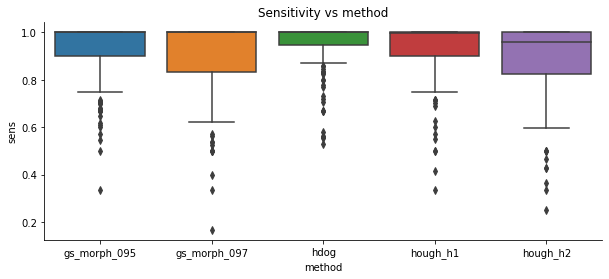

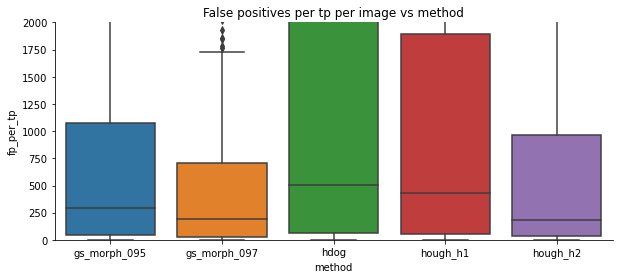

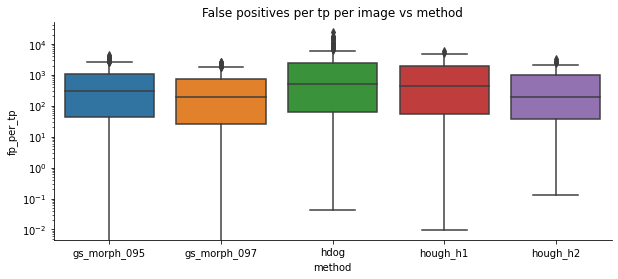

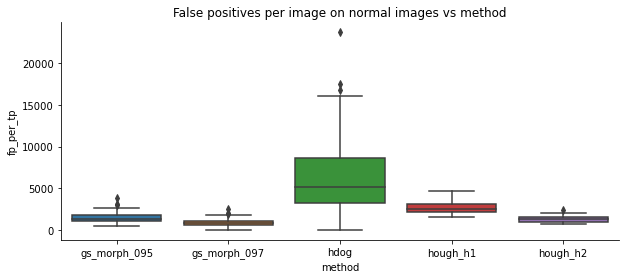

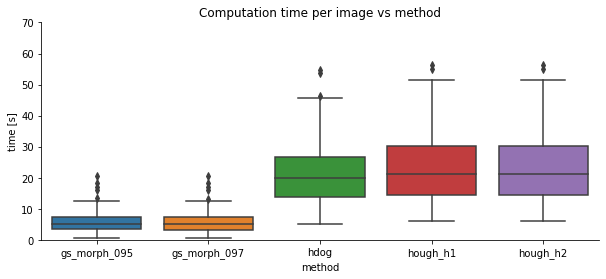

In [9]:

# GSM
threshold = 0.97
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=False)

threshold = 0.95
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=False)


# HDOG
dog_parameters = {
    'min_sigma': 1,
    'max_sigma': 3,
    'n_scales': 20,
    'sigma_ratio': None,
    'dog_blob_th': 0.006,
    'dog_overlap': 0.2,
    'dog_min_dist': 6,
}

hessian_parameters = {
    'method': 'eigenval',
    'hessian_threshold': None,
    'hessian_th_divider': 300
}

run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle=False)



# HOUGH

dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 10,
                 'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}
hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 3,  'minRadius': 2, 'maxRadius': 10}

back_ext_radius = 50
erosion_iter = 20
erosion_size = 5
min_hough2_distance = 6
run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius, erosion_iter,
    erosion_size, min_hough2_distance, db, results_path, filter_muscle=False
)


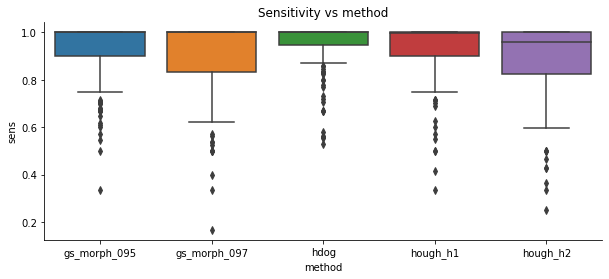

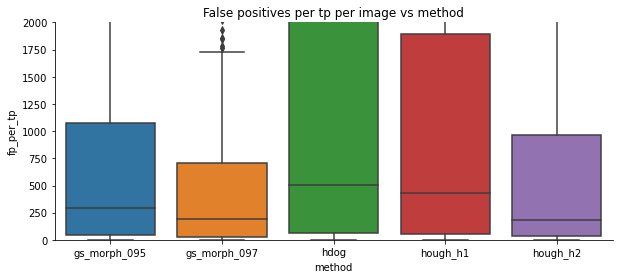

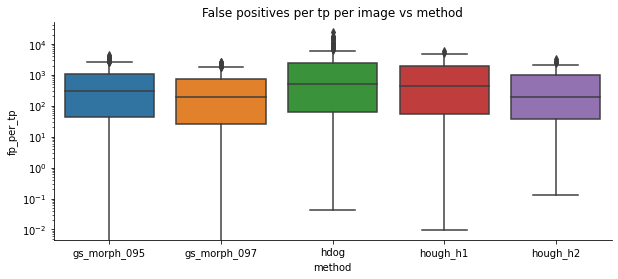

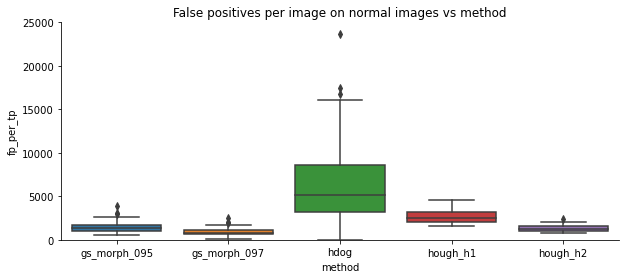

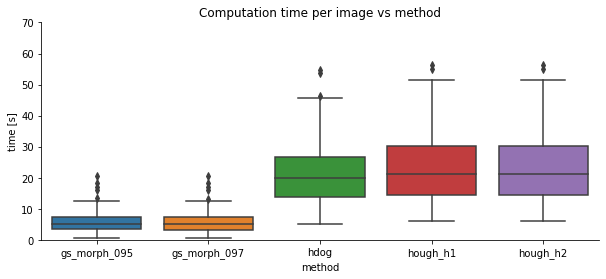

In [18]:
# RESULTS
plot_results(results_path)

## FAST CHECK ON VLAIDATION SET GSM

In [51]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=True,
    ignore_diameter_px = 15
)

threshold = 0.95
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=True)

results.loc[results.TP!= results.TP_wo_dup]

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,FPR,mfpi,sens,sens_wod,fp_per_tp
4,20587612,82,74,1629,14,12.439189,False,gs_morph_095,0.952075,1625.258065,0.854167,0.840909,19.865854
5,20587638,50,42,934,16,10.612072,False,gs_morph_095,0.949187,1625.258065,0.757576,0.724138,18.680000
6,20587664,78,72,1653,33,9.855016,False,gs_morph_095,0.954939,1625.258065,0.702703,0.685714,21.192308
7,20587690,55,49,2350,36,9.430161,False,gs_morph_095,0.977131,1625.258065,0.604396,0.576471,42.727273
15,22614150,4,3,3410,0,14.582123,False,gs_morph_095,0.998828,1625.258065,1.000000,1.000000,852.500000
20,24065680,10,7,897,7,4.766245,False,gs_morph_095,0.988975,1625.258065,0.588235,0.500000,89.700000
22,24065734,7,6,991,3,4.383419,False,gs_morph_095,0.992986,1625.258065,0.700000,0.666667,141.571429
23,24065761,20,17,1005,0,3.851923,False,gs_morph_095,0.980488,1625.258065,1.000000,1.000000,50.250000
25,30011507,26,20,497,2,1.421118,False,gs_morph_095,0.950287,1625.258065,0.928571,0.909091,19.115385
27,30011553,13,11,1077,1,5.552053,False,gs_morph_095,0.988073,1625.258065,0.928571,0.916667,82.846154


In [48]:
print(results.sens.mean(), results.sens.std())
print(results.sens_wod.mean(), results.sens_wod.std())

0.8442842291371703 0.22445380771063464
0.8374914767950603 0.2285453987492079


In [49]:
print(results.sens.median(), results.sens.quantile(0.25), results.sens.quantile(0.75))
print(results.sens_wod.median(), results.sens_wod.quantile(0.25), results.sens_wod.quantile(0.75))

1.0 0.7142857142857143 1.0
1.0 0.7142857142857143 1.0


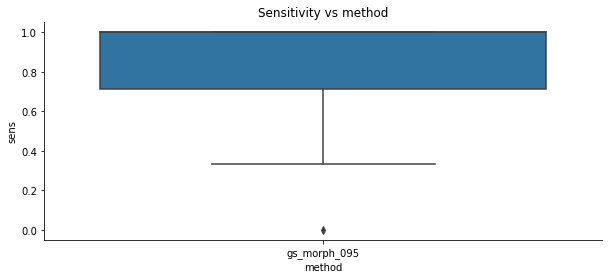

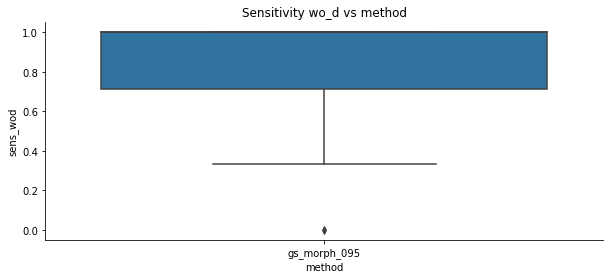

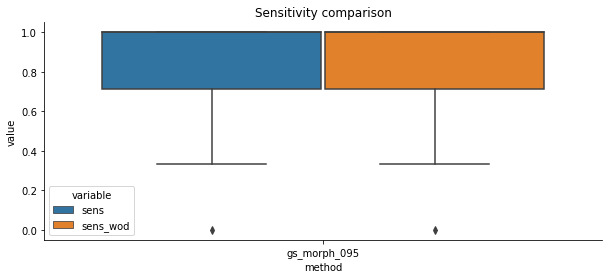

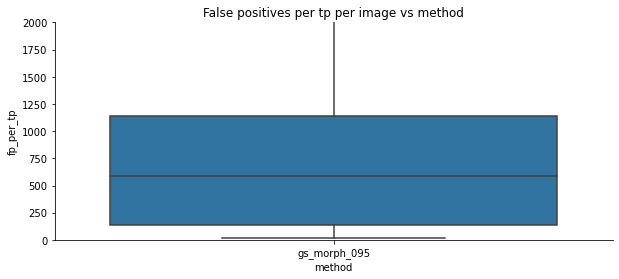

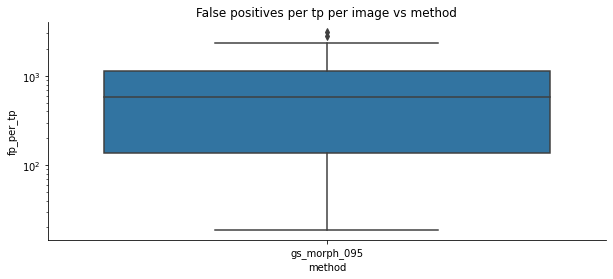

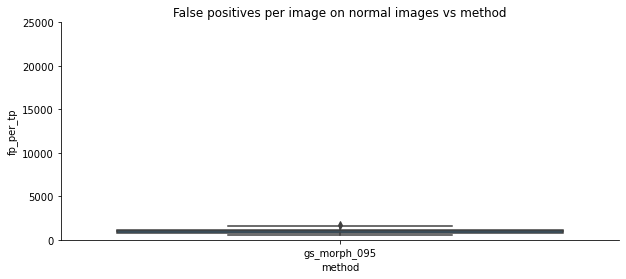

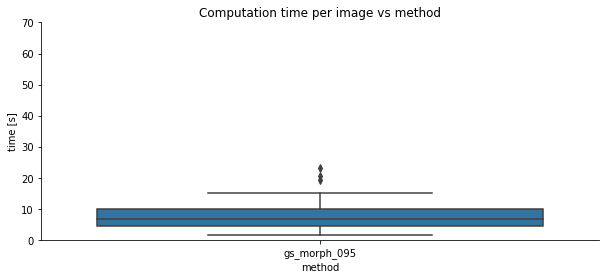

In [34]:
filename = 'md_th-0.95_mindist-6_area-14'
results_morphology95 = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
results_morphology95['method'] = 'gs_morph_095'
results = pd.concat([results_morphology95], ignore_index=True)

results['FPR'] = results['FP'] / (results['FP'] + results['TP'])
results['mfpi'] = (results['FP'] / len(results)).sum()
results['sens'] = results['TP'] / (results['TP'] + results['FN'])
results['sens_wod'] = results['TP_wo_dup'] / (results['TP_wo_dup'] + results['FN'])
results.loc[~results.normal, 'fp_per_tp'] = results['FP'] / (results['TP'])
results.loc[(~results.normal) & (results.sens==0), 'fp_per_tp'] = results['FP']
results.loc[results.normal, 'fp_per_tp'] = results['FP']

melt_results = pd.melt(results, id_vars=['method'], value_vars=['sens', 'sens_wod'])

plt.figure(figsize=(10, 4))
plt.title('Sensitivity vs method')
sns.boxplot(data=results, x='method', y='sens')
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Sensitivity wo_d vs method')
sns.boxplot(data=results, x='method', y='sens_wod')
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Sensitivity comparison')
sns.boxplot(data=melt_results, x='method', y='value', hue='variable')
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('False positives per tp per image vs method')
sns.boxplot(data=results, x='method', y='fp_per_tp')
plt.ylim(0, 2000)
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('False positives per tp per image vs method')
sns.boxplot(data=results, x='method', y='fp_per_tp')
plt.yscale('log')
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('False positives per image on normal images vs method')
sns.boxplot(data=results.loc[results.normal], x='method', y='fp_per_tp')
plt.ylim(0, 25000)
sns.despine()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Computation time per image vs method')
sns.boxplot(data=results, x='method', y='time')
# plt.yscale('log')
sns.despine()
plt.ylabel('time [s]')
plt.ylim([0, 70])
plt.show()